## Data Analysis

## Gradient Descent motivation: Minimizing an Arbitrary 1D Function

In [4]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

Suppose we want to find the minimum of the arbitrary function given below:

In [5]:
def arbitrary(x):
    return (x**4 - 15*x**3 + 80*x**2 - 180*x + 144)/10

x = np.linspace(1, 6.75, 200)
fig = px.line(y = arbitrary(x), x = x)


fig.update_layout(font_size = 16)

One way to minimize this mathematical function is to use the `scipy.optimize.minimize` function. It takes a function and a starting guess and tries to find the minimum.

In [8]:
from scipy.optimize import minimize

minimize(arbitrary, x0 = 3.5)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.13827491292966557
        x: [ 2.393e+00]
      nit: 3
      jac: [ 6.486e-06]
 hess_inv: [[ 7.385e-01]]
     nfev: 20
     njev: 10

Our choice of start point can affect the outcome. For example if we start to the left, we get stuck in the local minimum on the left side.

In [5]:
minimize(arbitrary, x0 = 1)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.13827491294422317
        x: [ 2.393e+00]
      nit: 7
      jac: [-3.800e-07]
 hess_inv: [[ 7.475e-01]]
     nfev: 16
     njev: 8

`scipy.optimize.minimize` is great. It may also seem a bit magical. How could you write a function that can find the minimum of any mathematical function? There are a number of ways to do this, which helps arriving at the important idea of **gradient descent**, which is the principle that `scipy.optimize.minimize` uses.

It turns out that under the hood, the `fit` method for `LinearRegression` models uses gradient descent. Gradient descent is also how much of machine learning works, including even advanced neural network models. 

In this course (and for many of the problems you will be working on in your future jobs), the gradient descent process will usually be invisible to you, hidden beneath an abstraction layer. However, to be good data scientists, it's important that we know the basic principles beyond the optimization functions that harness to find optimal parmaeters.

### The Naive Approach: Guess and Check

Above, we saw that the minimum is somewhere around 5.3ish. Let's see if we can figure out how to find the exact minimum algorithmically from scratch.

One way very slow and terrible way would be manual guess-and-check.

In [9]:
arbitrary(6)

0.0

A somewhat better approach is to use brute force to try out a bunch of x values and return the one that yields the lowest loss.

In [10]:
def simple_minimize(f, xs):
    y = [f(x) for x in xs]  
    return xs[np.argmin(y)]

In [11]:
simple_minimize(arbitrary, np.linspace(1, 7, 20))

5.421052631578947

This process is essentially the same as before where we made a graphical plot, it's just that we're only looking at 20 selected points.

In [12]:
xs = np.linspace(1, 7, 200)
sparse_xs = np.linspace(1, 7, 5)

ys = arbitrary(xs)
sparse_ys = arbitrary(sparse_xs)

fig = px.line(x = xs, y = arbitrary(xs))
fig.add_scatter(x = sparse_xs, y = arbitrary(sparse_xs), mode = "markers")
fig.update_layout(showlegend= False)
fig.show()

This basic approach suffers from three major flaws:
1. If the minimum is outside our range of guesses, the answer will be completely wrong.
2. Even if our range of guesses is correct, if the guesses are too coarse, our answer will be inaccurate.
3. It is absurdly computationally inefficient, considering potentially vast numbers of guesses that are useless.

### Better Approach: Gradient Descent

Instead of choosing all of our guesses ahead of time, we can instead start from a single guess and try to iteratively improve on our choice. 

They key insight is this: If the derivative of the function is negative, that means the function is decreasing, so we should go to the right (i.e. pick a bigger x). If the derivative of the function is positive, that means the function is increasing, so we should go to the left (i.e. pick a smaller x).

Thus, the derivative tells us which way to go.

In [13]:
#desmos demo: https://www.desmos.com/calculator/twpnylu4lr

In [14]:
import plotly.graph_objects as go

def derivative_arbitrary(x):
    return (4*x**3 - 45*x**2 + 160*x - 180)/10


fig = go.Figure()
roots = np.array([2.3927, 3.5309, 5.3263])

fig.add_trace(go.Scatter(x = xs, y = arbitrary(xs), 
                         mode = "lines", name = "f"))
fig.add_trace(go.Scatter(x = xs, y = derivative_arbitrary(xs), 
                         mode = "lines", name = "df", line = {"dash": "dash"}))
fig.add_trace(go.Scatter(x = np.array(roots), y = 0*roots, 
                         mode = "markers", name = "df = zero", marker_size = 12))
fig.update_layout(font_size = 20, yaxis_range=[-1, 3])
fig.show()

In [15]:
import matplotlib.pyplot as plt

def plot_arbitrary():
    x = np.linspace(1, 7, 100)
    plt.plot(x, arbitrary(x))
    axes = plt.gca()
    axes.set_ylim([-1, 3])
    
def plot_x_on_f(f, x):
    y = f(x)    
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([x], [y], **default_args)
    
def plot_x_on_f_empty(f, x):
    y = f(x)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c = 'none', edgecolor=sns.xkcd_rgb['green'])
    plt.scatter([x], [y], **default_args)    
    
def plot_tangent_on_f(f, x, eps=1e-6):
    slope = ((f(x + eps) - f(x - eps))
             / (2 * eps))
    xs = np.arange(x - 1, x + 1, 0.05)
    ys = f(x) + slope * (xs - x)
    plt.plot(xs, ys, zorder=3, c=sns.xkcd_rgb['green'], linestyle='--')    

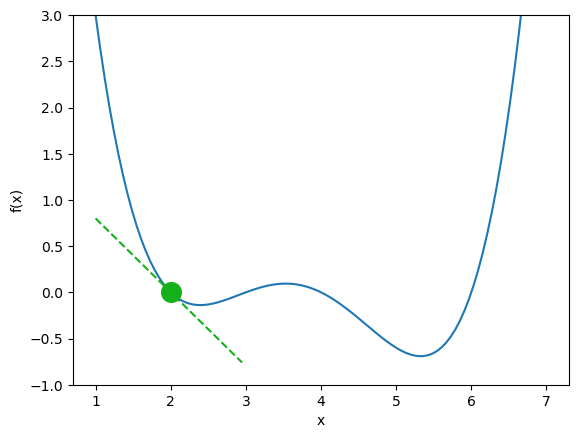

In [16]:
plot_arbitrary()
plot_x_on_f(arbitrary, 2)
plot_tangent_on_f(arbitrary, 2)
plt.xlabel('x')
plt.ylabel('f(x)');

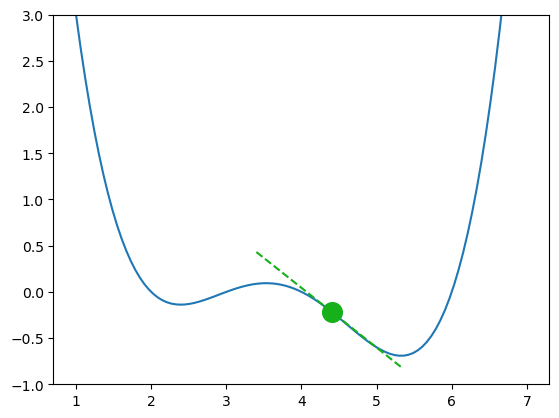

In [17]:
plot_arbitrary()
plot_x_on_f(arbitrary, 4.4)
plot_tangent_on_f(arbitrary, 4.4)

## Manually Descending the Gradient

Armed with this knowledge, let's try to see if we can use the derivative to optimize the function.

In [18]:
guess = 4
print(f"x: {guess}, f(x): {arbitrary(guess)}, derivative f'(x): {derivative_arbitrary(guess)}")

x: 4, f(x): 0.0, derivative f'(x): -0.4


In [19]:
guess = 4 + 0.4
print(f"x: {guess}, f(x): {arbitrary(guess)}, derivative f'(x): {derivative_arbitrary(guess)}")

x: 4.4, f(x): -0.21504000000003315, derivative f'(x): -0.6464000000000055


In [20]:
def plot_one_step(x):
    new_x = x - derivative_arbitrary(x)
    plot_arbitrary()
    plot_x_on_f(arbitrary, new_x)
    plot_x_on_f_empty(arbitrary, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.4


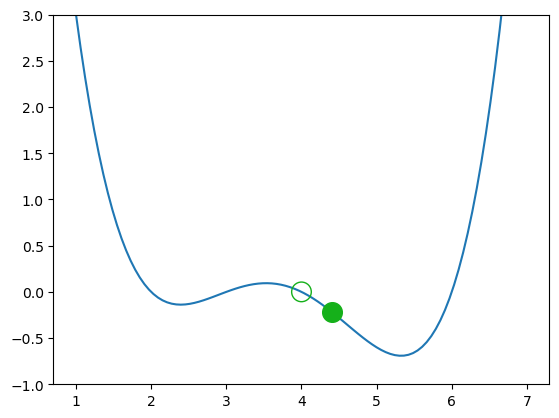

In [21]:
plot_one_step(4)

old x: 4.4
new x: 5.0464000000000055


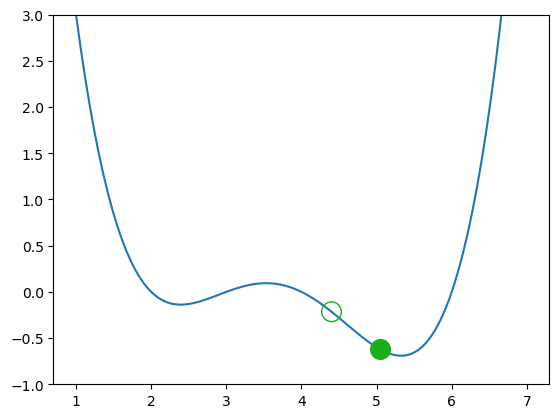

In [22]:
plot_one_step(4.4)

old x: 5.0464
new x: 5.49673060106241


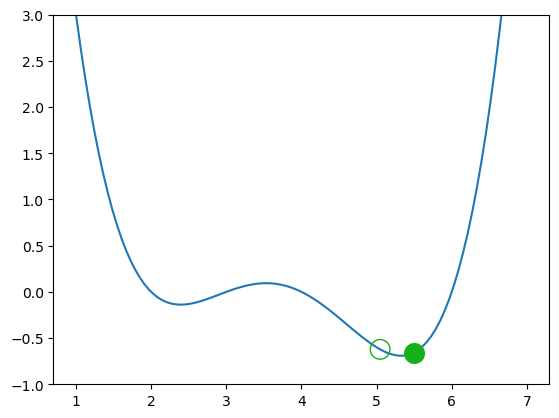

In [23]:
plot_one_step(5.0464)

old x: 5.4967
new x: 5.080917145374805


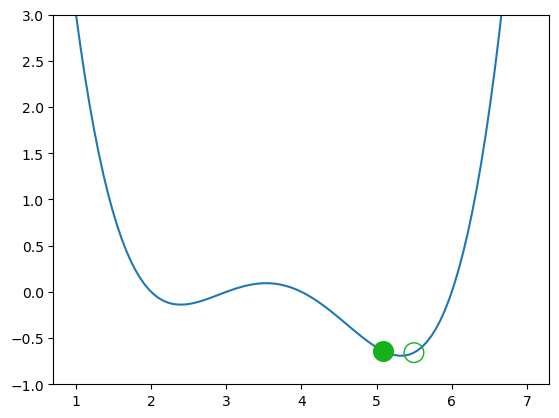

In [24]:
plot_one_step(5.4967)

old x: 5.080917145374805
new x: 5.489966698640582


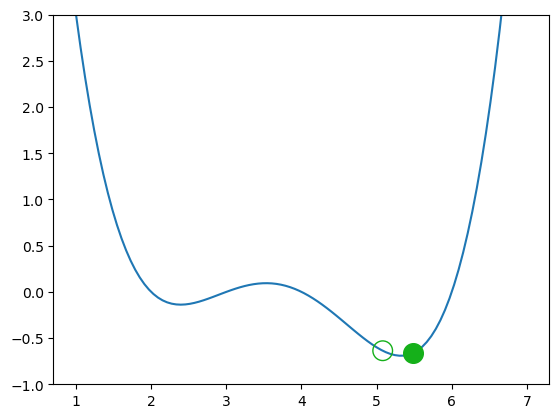

In [25]:
plot_one_step(5.080917145374805)

old x: 5.489966698640582
new x: 5.092848945470474


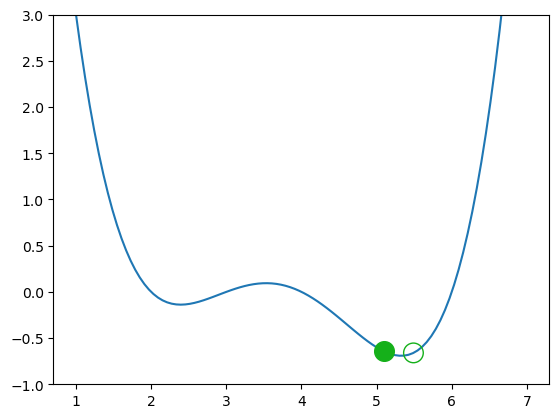

In [26]:
plot_one_step(5.489966698640582)

In [27]:
def plot_one_step_better(x):
    new_x = x - 0.3 * derivative_arbitrary(x)
    plot_arbitrary()
    plot_x_on_f(arbitrary, new_x)
    plot_x_on_f_empty(arbitrary, x)
    print(f'old x: {x}')
    print(f'new x: {new_x}')    

old x: 4
new x: 4.12


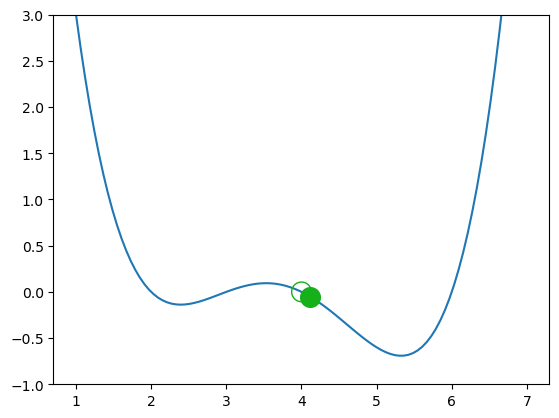

In [28]:
plot_one_step_better(4)

old x: 4.12
new x: 4.267296639999997


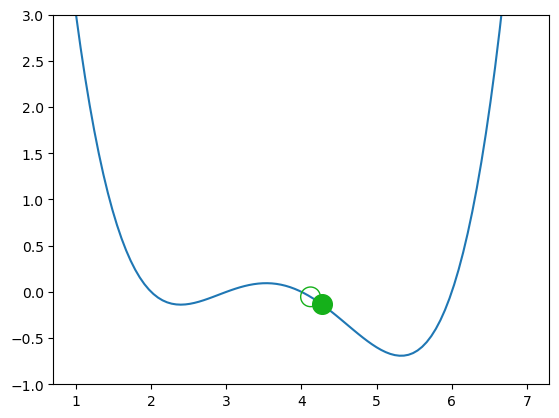

In [29]:
plot_one_step_better(4.12)

old x: 5.17180969114245
new x: 5.256374838146257


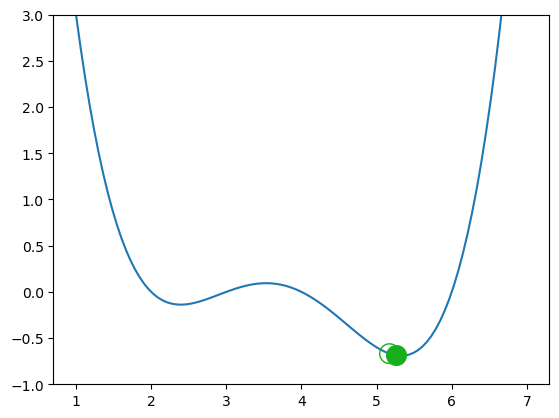

In [30]:
plot_one_step_better(5.17180969114245)

old x: 5.323
new x: 5.325108157959999


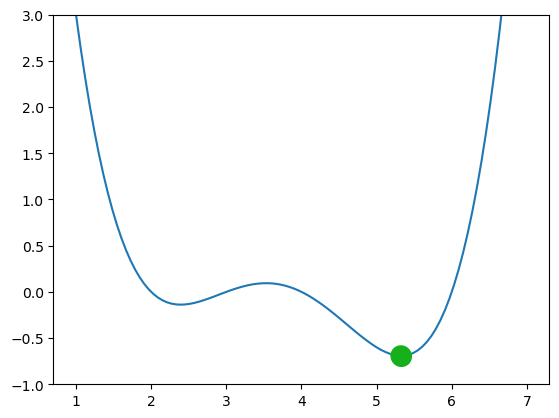

In [31]:
plot_one_step_better(5.323)

## Gradient Descent as an Algorithmic Procedure in Code

Written as a recurrence relation, the process we've described above is:

$$
x^{(t+1)} = x^{(t)} -  0.3 \frac{d}{dx} f(x)
$$

This algorithm is also known as "gradient descent". 

Given a current $x$, gradient descent creates its next guess for $x$ based on the sign and magnitude of the derivative.

Our choice of 0.3 above was totally arbitrary. Naturally, we can generalize by replacing it with a parameter, typically represented by $\alpha$, and often called the "learning rate".

$$
x^{(t+1)} = x^{(t)} -  \alpha \frac{d}{dx} f(x)
$$

We can also write up this procedure in code as given below:

In [32]:
def gradient_descent(df, initial_guess, alpha, n):
    """Performs n steps of gradient descent on df using learning rate alpha starting
       from initial_guess. Returns a numpy array of all guesses over time."""
    guesses = [initial_guess]
    current_guess = initial_guess
    while len(guesses) < n:
        current_guess = current_guess - alpha * df(current_guess)
        guesses.append(current_guess)
        
    return np.array(guesses)

In [33]:
trajectory = gradient_descent(derivative_arbitrary, 4, 0.3, 20)
trajectory

array([4.        , 4.12      , 4.26729664, 4.44272584, 4.64092624,
       4.8461837 , 5.03211854, 5.17201478, 5.25648449, 5.29791149,
       5.31542718, 5.3222606 , 5.32483298, 5.32578765, 5.32614004,
       5.32626985, 5.32631764, 5.32633523, 5.3263417 , 5.32634408])

In [34]:
trajectory = gradient_descent(derivative_arbitrary, 4, 1, 20)
trajectory

array([4.        , 4.4       , 5.0464    , 5.4967306 , 5.08086249,
       5.48998039, 5.09282487, 5.48675539, 5.09847285, 5.48507269,
       5.10140255, 5.48415922, 5.10298805, 5.48365325, 5.10386474,
       5.48336998, 5.1043551 , 5.48321045, 5.10463112, 5.48312031])

Below, we see a visualization of the trajectory taken by this algorithm.

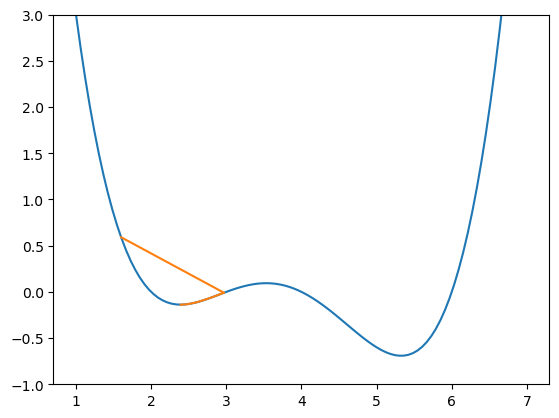

In [35]:
trajectory = gradient_descent(derivative_arbitrary, 1.6, 0.6, 20)
plot_arbitrary()
plt.plot(trajectory, arbitrary(trajectory));

Above, we've simply run our algorithm a fixed number of times. More sophisticated implementations will stop based on a variety of different stopping criteria, e.g. error getting too small, error getting too large, etc. We will not discuss these in our course.